In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
%matplotlib inline

In [4]:
# Fitting a beta distrbution 
from scipy.stats import beta

In [5]:
def generate_data_1D(job=0, n_samples=10000,data_vis=0, num_case=4):
    if job == 0: # discrete case
        pi1=np.random.uniform(0,0.3,size=num_case)
        X=np.random.randint(0, num_case, n_samples)
        
        p = np.zeros(n_samples)
        h = np.zeros(n_samples)
        
        for i in range(n_samples):
            rnd = np.random.uniform()
            if rnd > pi1[X[i]]:
                p[i] = np.random.uniform()
                h[i] = 0
            else:
                p[i] = np.random.beta(a = np.random.uniform(0.2,0.4), b = 4)
                h[i] = 1
        return p, h, X

def p_value_beta_fit(p, lamb=0.8, bin_num=50, vis=0):
    pi_0=np.divide(np.sum(p>lamb), p.shape[0] * (1-lamb))
    temp_p=np.zeros([0])
    step_size=np.divide(1,np.float(bin_num))
    fil_num=np.int(np.divide(pi_0*p.shape[0],bin_num))+1
    for i in range(bin_num):
        p1=p[p>step_size*(i-1)]
        p1=p1[p1 <= step_size*i]
        choice_num= np.max(p1.shape[0] - fil_num,0)
        if choice_num > 1:
            choice=np.random.choice(p1.shape[0], choice_num)
            temp_p=np.concatenate([temp_p,p1[choice]]).T
    if vis==1:
        plt.figure()
        plt.hist(temp_p, bins=100, normed=True)       
    a, b, loc, scale = beta.fit(temp_p,floc=0,fscale=1)
    return pi_0, a, b
def beta_mixture_pdf(x,pi_0,a,b):
    return beta.pdf(x,a,b)*(1-pi_0)+pi_0

def Storey_BH(x, alpha = 0.05, lamb=0.4):
    pi0_hat=np.divide(np.sum(x>lamb),x.shape[0] *(1-lamb))
    alpha /= pi0_hat
    x_s = sorted(x)
    n = len(x_s)
    ic = 0
    for i in range(n):
        if x_s[i] < i*alpha/float(n):
            ic = i
    return ic, x_s[ic], pi0_hat

def Opt_t_cal_discrete(p, h, X, num_case=2,step_size=0.0001,ub=0.05,n_samples=10000,alpha=0.05):
    # Fit the beta mixture parameters
    fit_param=np.zeros([num_case, 3])
    for i in range(num_case):
        fit_param[i,:]=p_value_beta_fit(p[X==i])

    # Calculating the ratios 
    t_opt=np.zeros([num_case])
    max_idx=np.argmin(fit_param[:,0])
    x_grid = np.arange(0, ub, step_size)
    t_ratio=np.zeros([num_case,x_grid.shape[0]])
    for i in range(num_case):
        t_ratio[i,:] = np.divide(beta_mixture_pdf(
            x_grid,fit_param[i,0],fit_param[i,1],fit_param[i,2]), fit_param[i,0])

    # Increase the threshold
    for i in range(len(x_grid)):
        t=np.zeros([num_case])
        # undate the search optimal threshold
        t[max_idx]=x_grid[i]
        c=t_ratio[max_idx,i]
        for j in range(num_case):
            if j != max_idx: 
                for k in range(len(x_grid)):
                    if k == len(x_grid)-1:
                        t[j]=x_grid[k]
                        break
                    if t_ratio[j,k+1]<c:
                        t[j]=x_grid[k]
                        break
        # calculate the FDR
        num_dis=0 
        num_fd =0 
        for i in range(num_case):
            num_dis+=np.sum(p[X==i] < t[i])
            num_fd+=np.sum(X==i)*t[i]*fit_param[i,0]

        if np.divide(num_fd,np.float(np.amax([num_dis,1])))<alpha:
            t_opt=t
        else:
            break
    return t_opt


In [7]:
## generating the data 
num_case=2
n_samples=10000
ub=0.1
p, h, X = generate_data_1D(num_case=num_case)
t_opt=Opt_t_cal_discrete(p, h, X,num_case=num_case)
print(t_opt)

# evaluation 
h_pred=np.zeros(n_samples)
for i in range(n_samples):
    if p[i]<t_opt[X[i]]:
        h_pred[i]=1

num_dis=np.sum(h_pred)
num_td=np.sum(h_pred*h)

ActFDR=1-np.divide(num_td,np.float(np.amax([num_dis,1])))

print('Number of dis:', num_dis, "Act FDR:", ActFDR)

dic_SBH, t_SBH, pi0_SBH = Storey_BH(p)
print("Storey_BH: num of dis, threshold, null esti", dic_SBH, t_SBH, pi0_SBH)


[ 0.0015  0.0057]
('Number of dis:', 579.0, 'Act FDR:', 0.037996545768566481)
('Storey_BH: num of dis, threshold, null esti', 550, 0.0033386840665412016, 0.82366666666666666)


In [334]:
np.sum(p<0.0029)

390

([<matplotlib.lines.Line2D at 0x7f53e3509450>],)

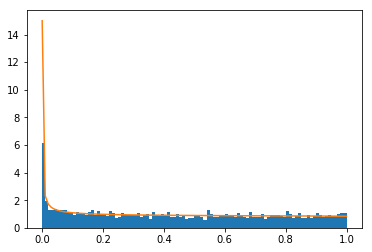

In [257]:
plt.figure()
hist_info = plt.hist(p[X==0], bins=100, normed=True)

x = hist_info[1]
plt.plot(x, (beta.pdf(x,a,b)*(1-pi_0)+pi_0).clip(max=15)),